In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
!cp './drive/MyDrive/Colab Notebooks/dataset/Violence/RootDataset.zip'  ./RootDataset.zip

In [ ]:
!unzip ./RootDataset.zip

In [ ]:
!pip install sk-video

In [ ]:
import os
import time
import sys
import pandas as pd
import numpy as np
import cv2
import pickle
import skvideo.io
import h5py
from tables import *
from sklearn import metrics
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG19,ResNet50
from tensorflow.keras.layers import LSTM , Dense , TimeDistributed, Flatten, Dropout, GlobalAveragePooling2D, GlobalAveragePooling1D, Input
from tensorflow.keras.layers import Reshape, BatchNormalization ,ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam , RMSprop, SGD

#Parameters
NUMBER_OF_FRAMES = 20
IMAGE_SIZE = 160
IMAGE_CHANNELS = 3

In [ ]:
dtframe = pd.DataFrame()
vid = []
lab = []

basepath = './HockeyFights/fight/'
for entry in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, entry)):
        vid.append(basepath + entry)
        lab.append(1)

basepath1 = './HockeyFights/no/'
for entry in os.listdir(basepath1):
    if os.path.isfile(os.path.join(basepath1, entry)):
        vid.append(basepath1 + entry)
        lab.append(0)

dtframe['video_name'] = vid
dtframe['tag'] = lab
dtframe.head

<bound method NDFrame.head of                               video_name  tag
0     ./HockeyFights/fight/fi99_xvid.avi    1
1    ./HockeyFights/fight/fi435_xvid.avi    1
2    ./HockeyFights/fight/fi118_xvid.avi    1
3    ./HockeyFights/fight/fi133_xvid.avi    1
4     ./HockeyFights/fight/fi20_xvid.avi    1
..                                   ...  ...
995     ./HockeyFights/no/no261_xvid.avi    0
996     ./HockeyFights/no/no429_xvid.avi    0
997     ./HockeyFights/no/no100_xvid.avi    0
998     ./HockeyFights/no/no427_xvid.avi    0
999      ./HockeyFights/no/no93_xvid.avi    0

[1000 rows x 2 columns]>

In [ ]:
dtframe2 = pd.DataFrame()
vid2 = []
lab2 = []

basepath = './Peliculas/fights/'
for entry in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, entry)):
        vid2.append(basepath + entry)
        lab2.append(1)

basepath1 = './Peliculas/noFights/'
for entry in os.listdir(basepath1):
    if os.path.isfile(os.path.join(basepath1, entry)):
        vid2.append(basepath1 + entry)
        lab2.append(0)

dtframe2['video_name'] = vid2
dtframe2['tag'] = lab2
dtframe2.head

<bound method NDFrame.head of                             video_name  tag
0        ./Peliculas/fights/newfi2.avi    1
1        ./Peliculas/fights/newfi3.avi    1
2       ./Peliculas/fights/newfi51.avi    1
3       ./Peliculas/fights/newfi88.avi    1
4    ./Peliculas/fights/newfi74avi.avi    1
..                                 ...  ...
196        ./Peliculas/noFights/57.mpg    0
197        ./Peliculas/noFights/27.mpg    0
198     ./Peliculas/noFights/71avi.mpg    0
199        ./Peliculas/noFights/90.mpg    0
200        ./Peliculas/noFights/98.mpg    0

[201 rows x 2 columns]>

In [ ]:
traindf = dtframe[:100]
traindf = traindf.append(dtframe2[:150],ignore_index= True)
valdf = dtframe[101:151]
valdf = valdf.append(dtframe2[151:189], ignore_index= True)
traindf = traindf.sample(frac=1).reset_index(drop=True)
valdf = valdf.sample(frac=1).reset_index(drop=True)

In [ ]:
def autocrop(image, threshold=0):
    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    assert len(flatImage.shape) == 2

    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatImage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]

    return image

In [ ]:
def scale_and_resize(image):

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = autocrop(image)
  image = cv2.resize(image,(IMAGE_SIZE,IMAGE_SIZE))
  image = image/255.0
  
  return image.astype('float16')
  

In [ ]:
def extract_frames(videodf, start_index = 0, end_index =-1):

  output_videos = []
  output_labels = []

  if end_index is -1:
    end_index = videodf.shape[0]
  for i in range(start_index, end_index):

    try:
      videodata = skvideo.io.vread(videodf['video_name'][i])

    except:
      continue

    steps = videodata.shape[0] // NUMBER_OF_FRAMES
    new_images = np.zeros((NUMBER_OF_FRAMES,IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS))

    for j in range(NUMBER_OF_FRAMES):
      new_images[j] = scale_and_resize(videodata[j*steps])

    output_videos.append(new_images)   
    output_labels.append(videodf['tag'][i])

    sys.stdout.write("\rVideo Processed " + str(i-start_index+1)+ "/" + str(end_index-start_index))
    sys.stdout.flush()

  output_videos = np.array(output_videos)
  output_labels = np.array(output_labels)
  
  return output_videos , output_labels

In [ ]:
def extract_frames_difference(videodf, start_index = 0, end_index =-1):
  
  output_videos = []
  output_labels = []

  if end_index is -1:
    end_index = videodf.shape[0]

  for i in range(start_index, end_index):

    try:
      videodata = skvideo.io.vread(videodf['video_name'][i])

    except:
      continue

    steps = videodata.shape[0] // NUMBER_OF_FRAMES
    new_images = []
    new_diff = np.zeros((int(NUMBER_OF_FRAMES/2),IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS))
    count = 0

    for j in range(NUMBER_OF_FRAMES):
      new_images.append(videodata[j*steps])

    for j in range(0,NUMBER_OF_FRAMES,2):
      new_diff[count] = scale_and_resize(cv2.absdiff(new_images[j],new_images[j+1]))
      count += 1 

    output_videos.append(new_diff)   
    output_labels.append(videodf['tag'][i])

    sys.stdout.write("\rVideo Processed " + str(i-start_index+1)+ "/" + str(end_index-start_index))
    sys.stdout.flush()

  output_videos = np.array(output_videos)
  output_labels = np.array(output_labels)
  
  return output_videos , output_labels

In [ ]:
fvideo , flabels = extract_frames(traindf)

Video Processed 250/250

In [ ]:
tvideo , tlabels = extract_frames(valdf)

Video Processed 88/88

In [ ]:
flabels = flabels.astype('float16')
#flabels = to_categorical(flabels ,num_classes=2)

tlabels = tlabels.astype('float16')
#tlabels = to_categorical(tlabels ,num_classes=2)

In [ ]:
print(fvideo.shape)
print(flabels.shape)

print(tvideo.shape)
print(tlabels.shape)

(250, 20, 160, 160, 3)
(250,)
(88, 20, 160, 160, 3)
(88,)


In [ ]:
hockey_video , hockey_labels = extract_frames(dtframe,300,400)

Video Processed 100/100

In [ ]:
movies_video , movies_labels = extract_frames(dtframe2,189,199)

Video Processed 10/10

In [ ]:
print(hockey_video.shape)
print(hockey_labels.shape)

print(movies_video.shape)
print(movies_labels.shape)

(100, 20, 160, 160, 3)
(100,)
(10, 20, 160, 160, 3)
(10,)


In [ ]:
'''
  This algorithm uses the history data from the training of the model (.fit)
  in order to plot the loss and accuracy at each epoch
'''
def plot_results(history):  
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.legend()

  plt.show()
  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.legend()

  plt.show()

In [ ]:
'''
  This method is responsible to evaluate a model which is passed as a 
  parameter to test it on both hockey and movies dataset
'''
def val_results(model):
  hockey_predictions = []

  for i in range(0,len(hockey_video)):
    hockey_predictions.append(model.predict(hockey_video[i:i+1])[0])

  count = 0
  count2 = 0

  for i in range(len(hockey_labels)):
    if hockey_predictions[i] > 0.5 and hockey_labels[i] == 1:
      count +=1 
    elif hockey_predictions[i] < 0.5 and hockey_labels[i] == 0:
      count +=1

  movies_predictions = model.predict(movies_video)

  for i in range(len(movies_labels)):
    if movies_predictions[i] > 0.5 and movies_labels[i] == 1:
      count2 +=1 
    elif movies_predictions[i] < 0.5 and movies_labels[i] == 0:
      count2 +=1
  
  print("count: ", count)
  print("len(hockey_labels): ", len(hockey_labels))
  print("Count2: ", count2)
  print("len(movies_labels): ", len(movies_labels))
  #print("Hockey Test Acc: " , float(count/len(hockey_labels)),"\tCount: " , count ,"\nMovies Test Acc: " ,float(count2/len(movies_labels)),"\tCount: " , count2)

In [ ]:
def CNN_LSTM(model_arch, opt, retrain ,init_weights = 'imagenet'):

    input_shapes=(NUMBER_OF_FRAMES,IMAGE_SIZE,IMAGE_SIZE,3)
    #np.random.seed(1234)
    if model_arch is 'Vgg19':
      base_model=VGG19(include_top=False,weights= init_weights ,input_shape=(IMAGE_SIZE, IMAGE_SIZE,3))
    elif model_arch is 'Resnet':
      base_model = ResNet50(include_top=False,weights=init_weights ,input_shape=(IMAGE_SIZE, IMAGE_SIZE,3))

    for layer in base_model.layers:
        layer.trainable = retrain

    cnn = TimeDistributed(base_model,  input_shape=(NUMBER_OF_FRAMES, IMAGE_SIZE, IMAGE_SIZE, 3))
    
    model = Sequential()
    #model.add(Input(shape=(NUMBER_OF_FRAMES, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)))
    model.add(cnn)
    model.add(TimeDistributed(Flatten()))

    
    model.add(LSTM(NUMBER_OF_FRAMES+80 , return_sequences= True))
    model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(90, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(GlobalAveragePooling1D())
    model.add(BatchNormalization())
    model.add(Dense(90, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation="sigmoid"))

    if opt is 'Adam':
      opti = Adam(lr=0.00001)
    elif opt is 'Sgd':
      opti = SGD(lr=0.00001)
    elif opt is 'RMSprop':
      opti = RMSprop(lr=0.00001)

    model.compile(loss='BinaryCrossentropy', optimizer= opti, metrics=["accuracy"])

    return model

In [ ]:
vgg_adam_retrain = CNN_LSTM('Vgg19', 'Adam', True)
vgg_adam_retrain_history = vgg_adam_retrain.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

80142336/80134624 [==============================] - 3s 0us/step
Epoch 1/20
25/25 [==============================] - 37s 944ms/step - loss: 0.7821 - accuracy: 0.5420 - val_loss: 0.6502 - val_accuracy: 0.5682
Epoch 2/20
25/25 [==============================] - 21s 853ms/step - loss: 0.7108 - accuracy: 0.6222 - val_loss: 0.6048 - val_accuracy: 0.8750
Epoch 3/20
25/25 [==============================] - 21s 854ms/step - loss: 0.5662 - accuracy: 0.6808 - val_loss: 0.5771 - val_accuracy: 0.9318
Epoch 4/20
25/25 [==============================] - 21s 854ms/step - loss: 0.5534 - accuracy: 0.7279 - val_loss: 0.5921 - val_accuracy: 0.8977
Epoch 5/20
25/25 [==============================] - 21s 853ms/step - loss: 0.6022 - accuracy: 0.6839 - val_loss: 0.5799 - val_accuracy: 0.8636
Epoch 6/20
25/25 [==============================] - 21s 854ms/step - loss: 0.5321 - accuracy: 0.7073 - val_loss: 0.4899 - val_accuracy: 0.9205
Epoch 7/20
25/25 [==============================] - 21s 853ms/step - loss: 0.

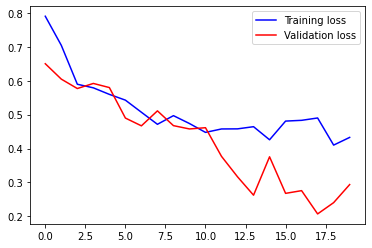

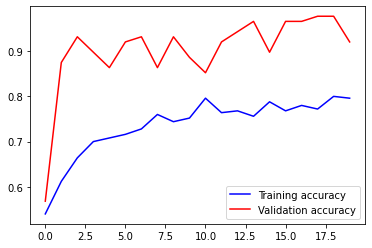

In [ ]:
plot_results(vgg_adam_retrain_history)

In [ ]:
val_results(vgg_adam_retrain)

count:  91
len(hockey_labels):  100
Count2:  10
len(movies_labels):  10


In [ ]:
vgg_adam_static = CNN_LSTM('Vgg19', 'Adam', False)
vgg_adam_static_history = vgg_adam_static.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
25/25 [==============================] - 11s 358ms/step - loss: 0.9843 - accuracy: 0.4215 - val_loss: 0.6787 - val_accuracy: 0.5455
Epoch 2/20
25/25 [==============================] - 8s 329ms/step - loss: 0.8136 - accuracy: 0.5227 - val_loss: 0.6503 - val_accuracy: 0.5795
Epoch 3/20
25/25 [==============================] - 8s 329ms/step - loss: 0.6852 - accuracy: 0.6332 - val_loss: 0.6139 - val_accuracy: 0.7500
Epoch 4/20
25/25 [==============================] - 8s 335ms/step - loss: 0.7092 - accuracy: 0.5669 - val_loss: 0.5693 - val_accuracy: 0.8523
Epoch 5/20
25/25 [==============================] - 8s 329ms/step - loss: 0.6608 - accuracy: 0.5887 - val_loss: 0.5422 - val_accuracy: 0.8523
Epoch 6/20
25/25 [==============================] - 8s 329ms/step - loss: 0.6395 - accuracy: 0.6642 - val_loss: 0.5055 - val_accuracy: 0.8864
Epoch 7/20
25/25 [==============================] - 8s 329ms/step - loss: 0.5273 - accuracy: 0.7255 - val_loss: 0.4724 - val_accuracy: 0.8977
Epoch

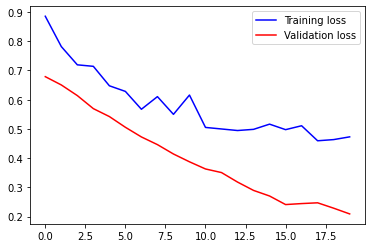

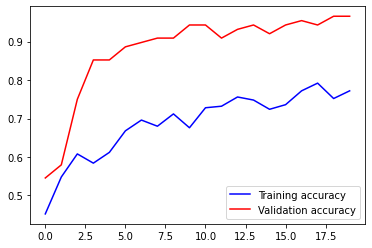

In [ ]:
plot_results(vgg_adam_static_history)

In [ ]:
val_results(vgg_adam_static)

count:  97
len(hockey_labels):  100
Count2:  10
len(movies_labels):  10


In [ ]:
resnet_adam_static = CNN_LSTM('Resnet', 'Adam', False)
resnet_adam_static_history = resnet_adam_static.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

94773248/94765736 [==============================] - 3s 0us/step
Epoch 1/20
25/25 [==============================] - 13s 333ms/step - loss: 0.8823 - accuracy: 0.4748 - val_loss: 0.6732 - val_accuracy: 0.7273
Epoch 2/20
25/25 [==============================] - 6s 247ms/step - loss: 0.8193 - accuracy: 0.5223 - val_loss: 0.6627 - val_accuracy: 0.5568
Epoch 3/20
25/25 [==============================] - 6s 247ms/step - loss: 0.7399 - accuracy: 0.6227 - val_loss: 0.6601 - val_accuracy: 0.7386
Epoch 4/20
25/25 [==============================] - 6s 254ms/step - loss: 0.6558 - accuracy: 0.6298 - val_loss: 0.6505 - val_accuracy: 0.5568
Epoch 5/20
25/25 [==============================] - 6s 247ms/step - loss: 0.6973 - accuracy: 0.5976 - val_loss: 0.6434 - val_accuracy: 0.5795
Epoch 6/20
25/25 [==============================] - 6s 247ms/step - loss: 0.6659 - accuracy: 0.6424 - val_loss: 0.6251 - val_accuracy: 0.5682
Epoch 7/20
25/25 [==============================] - 6s 247ms/step - loss: 0.5956 -

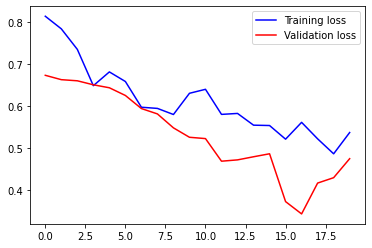

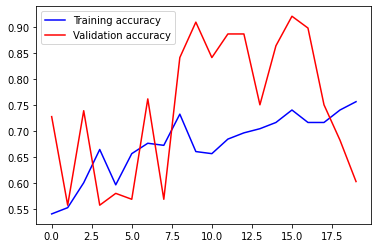

In [ ]:
plot_results(resnet_adam_static_history)

In [ ]:
val_results(resnet_adam_static)

count:  100
len(hockey_labels):  100
Count2:  3
len(movies_labels):  10


In [ ]:
resnet_rmsprop_static = CNN_LSTM('Resnet', 'RMSprop', False)
resnet_rmsprop_static_history = resnet_rmsprop_static.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
25/25 [==============================] - 13s 319ms/step - loss: 0.8738 - accuracy: 0.5082 - val_loss: 0.6767 - val_accuracy: 0.5682
Epoch 2/20
25/25 [==============================] - 6s 249ms/step - loss: 0.8441 - accuracy: 0.5075 - val_loss: 0.6747 - val_accuracy: 0.5682
Epoch 3/20
25/25 [==============================] - 6s 250ms/step - loss: 0.7748 - accuracy: 0.6019 - val_loss: 0.6658 - val_accuracy: 0.5682
Epoch 4/20
25/25 [==============================] - 6s 250ms/step - loss: 0.6470 - accuracy: 0.6672 - val_loss: 0.6439 - val_accuracy: 0.5682
Epoch 5/20
25/25 [==============================] - 6s 250ms/step - loss: 0.7355 - accuracy: 0.5967 - val_loss: 0.6033 - val_accuracy: 0.9091
Epoch 6/20
25/25 [==============================] - 6s 250ms/step - loss: 0.5693 - accuracy: 0.6915 - val_loss: 0.6055 - val_accuracy: 0.7045
Epoch 7/20
25/25 [==============================] - 6s 250ms/step - loss: 0.6171 - accuracy: 0.6557 - val_loss: 0.6310 - val_accuracy: 0.6023
Epoch

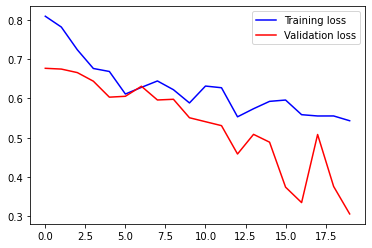

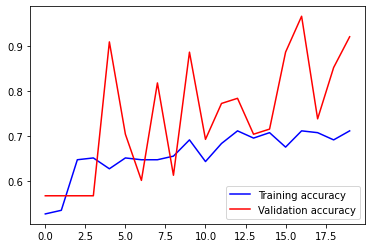

In [ ]:
plot_results(resnet_rmsprop_static_history)

In [ ]:
val_results(resnet_rmsprop_static)

count:  88
len(hockey_labels):  100
Count2:  7
len(movies_labels):  10


In [ ]:
fvideo , flabels = extract_frames_difference(traindf)

Video Processed 250/250

In [ ]:
tvideo , tlabels = extract_frames_difference(valdf)

Video Processed 88/88

In [ ]:
flabels = flabels.astype('float16')
#flabels = to_categorical(flabels ,num_classes=2)

tlabels = tlabels.astype('float16')
#tlabels = to_categorical(tlabels ,num_classes=2)

In [ ]:
print(fvideo.shape)
print(flabels.shape)

print(tvideo.shape)
print(tlabels.shape)

(250, 10, 160, 160, 3)
(250,)
(88, 10, 160, 160, 3)
(88,)


In [ ]:
hockey_video , hockey_labels = extract_frames_difference(dtframe,300,400)

Video Processed 100/100

In [ ]:
movies_video , movies_labels = extract_frames_difference(dtframe2,189,199)

Video Processed 10/10

In [ ]:
print(hockey_video.shape)
print(hockey_labels.shape)

print(movies_video.shape)
print(movies_labels.shape)

(100, 10, 160, 160, 3)
(100,)
(10, 10, 160, 160, 3)
(10,)


In [ ]:
'''
  Defining the second model which uses the difference between frames to classify the action
'''
def CNN_CONVLSTM(model_arch, opt, retrain ,init_weights = 'imagenet'):

    input_shapes=(int(NUMBER_OF_FRAMES/2),IMAGE_SIZE,IMAGE_SIZE,3)

    if model_arch is 'Vgg19':
      base_model=VGG19(include_top=False,weights= init_weights ,input_shape=(IMAGE_SIZE, IMAGE_SIZE,3))
    elif model_arch is 'Resnet':
      base_model = ResNet50(include_top=False,weights=init_weights ,input_shape=(IMAGE_SIZE, IMAGE_SIZE,3))

    for layer in base_model.layers:
        layer.trainable = retrain

    cnn = TimeDistributed(base_model,  input_shape=input_shapes)
    
    model = Sequential()
    model.add(cnn)
    #model.add(TimeDistributed(Flatten()))

    
    model.add(ConvLSTM2D(filters=20, kernel_size=(3, 3),return_sequences=True))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation="sigmoid"))

    if opt is 'Adam':
      opti = Adam(lr=0.00001)
    elif opt is 'Sgd':
      opti = SGD(lr=0.00001)
    elif opt is 'RMSprop':
      opti = RMSprop(lr=0.00001)

    model.compile(loss='BinaryCrossentropy', optimizer= opti, metrics=["accuracy"])

    return model

In [ ]:
diff_vgg_rmsprop_retrain = CNN_CONVLSTM('Vgg19', 'RMSprop', True)
diff_vgg_rmsprop_retrain_history = diff_vgg_rmsprop_retrain.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
25/25 [==============================] - 22s 629ms/step - loss: 0.7903 - accuracy: 0.5384 - val_loss: 0.6726 - val_accuracy: 0.5682
Epoch 2/20
25/25 [==============================] - 14s 573ms/step - loss: 0.6175 - accuracy: 0.6898 - val_loss: 0.6389 - val_accuracy: 0.5682
Epoch 3/20
25/25 [==============================] - 14s 573ms/step - loss: 0.5434 - accuracy: 0.7890 - val_loss: 0.6053 - val_accuracy: 0.5682
Epoch 4/20
25/25 [==============================] - 14s 572ms/step - loss: 0.5559 - accuracy: 0.7623 - val_loss: 0.5577 - val_accuracy: 0.6364
Epoch 5/20
25/25 [==============================] - 14s 572ms/step - loss: 0.3972 - accuracy: 0.8929 - val_loss: 0.5693 - val_accuracy: 0.5909
Epoch 6/20
25/25 [==============================] - 14s 573ms/step - loss: 0.5151 - accuracy: 0.7574 - val_loss: 0.5256 - val_accuracy: 0.7727
Epoch 7/20
25/25 [==============================] - 14s 572ms/step - loss: 0.3639 - accuracy: 0.8308 - val_loss: 0.4807 - val_accuracy: 0.8977

In [ ]:
diff_vgg_rmsprop_retrain.save("./drive/MyDrive/Colab Notebooks/model/ViolenceDetection_RootDataset.h5")

In [ ]:
diff_vgg_rmsprop_retrain.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, 10, 5, 5, 512)     20024384  
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 10, 3, 3, 20)      383120    
_________________________________________________________________
flatten_4 (Flatten)          (None, 1800)              0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 1800)              7200      
_________________________________________________________________
dense_12 (Dense)             (None, 256)               461056    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

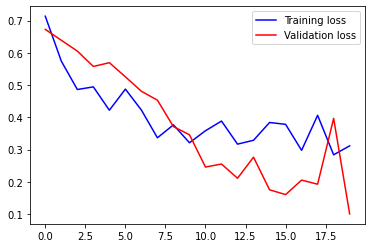

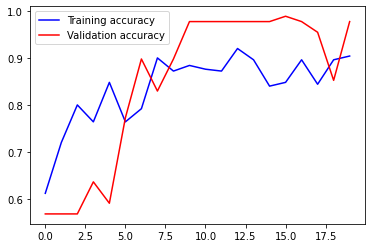

In [ ]:
plot_results(diff_vgg_rmsprop_retrain_history)

In [ ]:
val_results(diff_vgg_rmsprop_retrain)

count:  98
len(hockey_labels):  100
Count2:  10
len(movies_labels):  10


In [ ]:
diff_vgg_rmsprop_static = CNN_CONVLSTM('Vgg19', 'RMSprop', False)
diff_vgg_rmsprop_static_history = diff_vgg_rmsprop_static.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
25/25 [==============================] - 9s 256ms/step - loss: 0.8115 - accuracy: 0.5655 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/20
25/25 [==============================] - 5s 219ms/step - loss: 0.7103 - accuracy: 0.6271 - val_loss: 0.6810 - val_accuracy: 0.5682
Epoch 3/20
25/25 [==============================] - 5s 220ms/step - loss: 0.6738 - accuracy: 0.6909 - val_loss: 0.6851 - val_accuracy: 0.5682
Epoch 4/20
25/25 [==============================] - 5s 219ms/step - loss: 0.6577 - accuracy: 0.6659 - val_loss: 0.6922 - val_accuracy: 0.5682
Epoch 5/20
25/25 [==============================] - 5s 219ms/step - loss: 0.6831 - accuracy: 0.6844 - val_loss: 0.6897 - val_accuracy: 0.5682
Epoch 6/20
25/25 [==============================] - 5s 219ms/step - loss: 0.4658 - accuracy: 0.7986 - val_loss: 0.6900 - val_accuracy: 0.5682
Epoch 7/20
25/25 [==============================] - 5s 220ms/step - loss: 0.5240 - accuracy: 0.7322 - val_loss: 0.6665 - val_accuracy: 0.5682
Epoch 

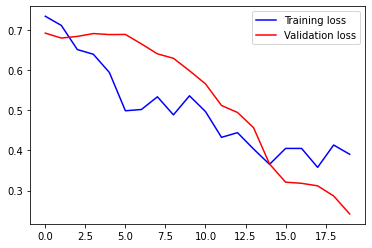

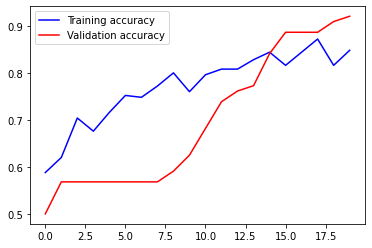

In [ ]:
plot_results(diff_vgg_rmsprop_static_history)

In [ ]:
val_results(diff_vgg_rmsprop_static)

count:  97
len(hockey_labels):  100
Count2:  7
len(movies_labels):  10


In [ ]:
diff_vgg_adam_retrain = CNN_CONVLSTM('Vgg19', 'Adam', True)
diff_vgg_adam_retrain_history = diff_vgg_adam_retrain.fit(fvideo,flabels, batch_size=10, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
25/25 [==============================] - 17s 591ms/step - loss: 0.7524 - accuracy: 0.5897 - val_loss: 0.6668 - val_accuracy: 0.4432
Epoch 2/20
25/25 [==============================] - 14s 569ms/step - loss: 0.5468 - accuracy: 0.7376 - val_loss: 0.6533 - val_accuracy: 0.4545
Epoch 3/20
25/25 [==============================] - 14s 569ms/step - loss: 0.5198 - accuracy: 0.7332 - val_loss: 0.6249 - val_accuracy: 0.4545
Epoch 4/20
25/25 [==============================] - 14s 570ms/step - loss: 0.5116 - accuracy: 0.7641 - val_loss: 0.6455 - val_accuracy: 0.4318
Epoch 5/20
25/25 [==============================] - 14s 569ms/step - loss: 0.4762 - accuracy: 0.7554 - val_loss: 0.5689 - val_accuracy: 0.4432
Epoch 6/20
25/25 [==============================] - 14s 569ms/step - loss: 0.4659 - accuracy: 0.8054 - val_loss: 0.5985 - val_accuracy: 0.5682
Epoch 7/20
25/25 [==============================] - 14s 569ms/step - loss: 0.3345 - accuracy: 0.8433 - val_loss: 0.5360 - val_accuracy: 0.5795

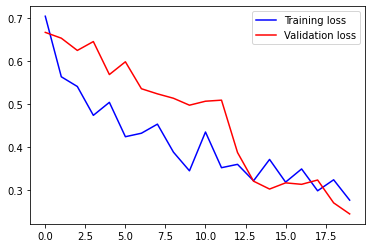

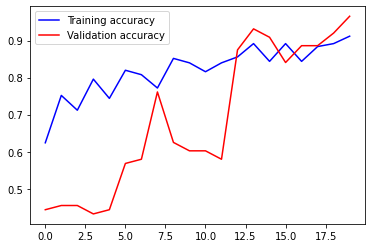

In [ ]:
plot_results(diff_vgg_adam_retrain_history)

In [ ]:
val_results(diff_vgg_adam_retrain)

count:  82
len(hockey_labels):  100
Count2:  9
len(movies_labels):  10


In [ ]:
diff_resnet_rmsprop_retrain = CNN_CONVLSTM('Resnet', 'RMSprop', True)
diff_resnet_rmsprop_retrain_history = diff_resnet_rmsprop_retrain.fit(fvideo,flabels, batch_size=20, epochs=20, validation_data=(tvideo , tlabels))

Epoch 1/20
13/13 [==============================] - 27s 1s/step - loss: 0.8166 - accuracy: 0.5296 - val_loss: 0.7020 - val_accuracy: 0.5568
Epoch 2/20
13/13 [==============================] - 10s 791ms/step - loss: 0.6534 - accuracy: 0.6271 - val_loss: 0.7249 - val_accuracy: 0.4318
Epoch 3/20
13/13 [==============================] - 10s 790ms/step - loss: 0.6174 - accuracy: 0.6812 - val_loss: 0.7660 - val_accuracy: 0.4318
Epoch 4/20
13/13 [==============================] - 10s 790ms/step - loss: 0.5392 - accuracy: 0.7664 - val_loss: 0.7889 - val_accuracy: 0.4318
Epoch 5/20
13/13 [==============================] - 10s 789ms/step - loss: 0.4780 - accuracy: 0.7522 - val_loss: 0.8087 - val_accuracy: 0.4318
Epoch 6/20
13/13 [==============================] - 10s 790ms/step - loss: 0.5440 - accuracy: 0.7068 - val_loss: 0.8114 - val_accuracy: 0.4318
Epoch 7/20
13/13 [==============================] - 10s 791ms/step - loss: 0.4334 - accuracy: 0.8139 - val_loss: 0.8371 - val_accuracy: 0.4318
Ep

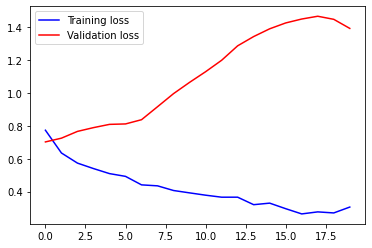

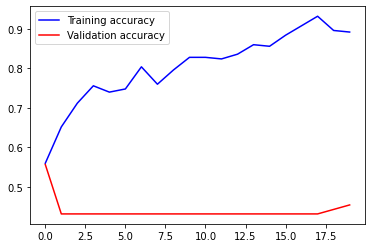

In [ ]:
plot_results(diff_resnet_rmsprop_retrain_history)

In [ ]:
val_results(diff_resnet_rmsprop_retrain)

count:  4
len(hockey_labels):  100
Count2:  10
len(movies_labels):  10
